# 处理流程
- 将原始数据集随机打乱，得到**乱序数据集**；
- 可视化乱序数据集的上下文长度分布；
- 保存乱序数据集。

In [1]:
from abc import abstractmethod
import gc
import logging
import random
from tqdm import tqdm
from transformers import StoppingCriteria
import numpy as np
from collections import defaultdict
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import StoppingCriteriaList

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

import argparse
import pickle

import logging
import os
import json
import hashlib
import datasets

from collections import Counter
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = os.getenv("DATA_DIR")
print(f"DATA_DIR: {DATA_DIR}")

DATA_DIR: /home/song/dataset


In [3]:
# 使用镜像
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

def md5hash(s: str) -> str:
    '''将字符串s序列化'''
    import hashlib
    return str(int(hashlib.md5(str(s).encode('utf-8')).hexdigest(), 16))

In [4]:
# 加载数据集
dataset = datasets.load_dataset('TimoImhof/TriviaQA-in-SQuAD-format')['unmodified']
print(dataset)

Found cached dataset parquet (/home/song/.cache/huggingface/datasets/TimoImhof___parquet/TimoImhof--TriviaQA-in-SQuAD-format-9e289a26688c4d08/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'question', 'context', 'answers'],
    num_rows: 15368
})


In [5]:
reformat = lambda x: {
    'id': md5hash(x['id']),
    'origin_id': x['id'],
    'question': x['question'],
    'context': x['context'],
    'answers': x['answers']['text'],
}

dataset = [reformat(d) for d in dataset if d['answers']['text']]
dataset[0], len(dataset)

({'id': '164649986527822701568107714546363251126',
  'origin_id': 'tc_276--Hold_On_to_the_Nights.txt#0',
  'question': 'Who had an 80s No 1 hit with Hold On To The Nights?',
  'context': '[DOC] [TLE] Hold On to the Nights"Hold On to the Nights" is a power ballad and number-one hit for American rock singer/songwriter/musician Richard Marx.  This was the fourth and final single released from his self-titled debut album, and the first to reach the top of the Billboard Hot 100 chart. [PAR] Written by Richard Marx, "Hold On to the Nights" reached the Billboard Hot 100 number 1 position on July 23, 1988, preventing Def Leppard\'s "Pour Some Sugar On Me" from reaching the top spot that same week. The song was on the chart for twenty-one weeks, and left the chart at number 65. From Marx\' debut 1987 album, Richard Marx, the song also reached number three on the Billboard Adult Contemporary chart. "Hold On to the Nights" has been re-released numerous albums  and is included on Marx\'s live perf

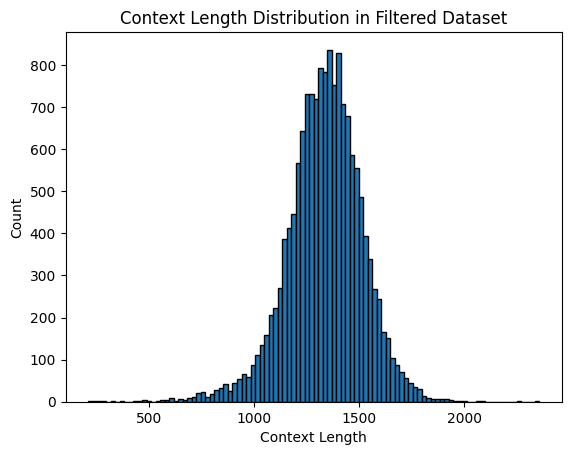

In [6]:
# 可视化上下文长度分布
def plot_context_length(dataset):
    context_lengths = [len(d['context']) for d in dataset]
    plt.hist(context_lengths, bins=100, edgecolor='black')
    plt.xlabel('Context Length')
    plt.ylabel('Count')
    plt.title('Context Length Distribution in Filtered Dataset')
    plt.show()

plot_context_length(dataset)

In [7]:
# 固定随机数种子
random.seed(42)
# 将原数据集打乱
random.shuffle(dataset)

# 将原数据集按8:1:1分为train, validation, test数据集
total_size = len(dataset)
train_size = int(total_size * 0.8)
validation_size = int(total_size * 0.1)
new_train_dataset = dataset[:train_size]
new_validation_dataset = dataset[train_size:train_size + validation_size]
new_test_dataset = dataset[train_size + validation_size:]
print(len(new_train_dataset), len(new_validation_dataset), len(new_test_dataset))

12294 1536 1538


In [8]:
# 添加无关上下文
def add_irrelevant_context(dataset):
    # 构建id-context字典
    id_context_dict = {d['id']: d['context'] for d in dataset}
    # 数据集id列表
    id_list = [d['id'] for d in dataset]

    while True:
        # 生成新的id列表
        shuffled_id_list = id_list.copy()
        random.shuffle(shuffled_id_list)
        # 确认新旧id列表对应位置不相同
        if all(shuffled_id_list[i] != id_list[i] for i in range(len(id_list))):
            break

    # 在原数据集中增加字段
    for i in range(len(dataset)):
        dataset[i]['irrelevant_id'] = shuffled_id_list[i]
        dataset[i]['irrelevant_context'] = id_context_dict[shuffled_id_list[i]]

    return dataset

new_train_dataset = add_irrelevant_context(new_train_dataset)
new_validation_dataset = add_irrelevant_context(new_validation_dataset)
new_test_dataset = add_irrelevant_context(new_test_dataset)

In [9]:
# 合并成一个DatasetDict
dataset = datasets.DatasetDict({
    'train': datasets.Dataset.from_list(new_train_dataset),
    'validation': datasets.Dataset.from_list(new_validation_dataset),
    'test': datasets.Dataset.from_list(new_test_dataset),
})
print(dataset)

# 保存新数据集
dataset.save_to_disk(f"{DATA_DIR}/song/triviaqa")
print(f"Saved to {DATA_DIR}/song/triviaqa")

DatasetDict({
    train: Dataset({
        features: ['id', 'origin_id', 'question', 'context', 'answers', 'irrelevant_id', 'irrelevant_context'],
        num_rows: 12294
    })
    validation: Dataset({
        features: ['id', 'origin_id', 'question', 'context', 'answers', 'irrelevant_id', 'irrelevant_context'],
        num_rows: 1536
    })
    test: Dataset({
        features: ['id', 'origin_id', 'question', 'context', 'answers', 'irrelevant_id', 'irrelevant_context'],
        num_rows: 1538
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/12294 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1536 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1538 [00:00<?, ? examples/s]

Saved to /home/song/dataset/song/triviaqa
